In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
from scipy import integrate
from scipy import stats
import statsmodels.api as sm
import math
import seaborn as sns

In [2]:
path0 = '../../data/commaai/train_bags_2/0/angles_filename.csv'
path1 = '../../data/commaai/train_bags_2/1/angles_filename.csv'
path2 = '../../data/commaai/train_bags_2/2/angles_filename.csv'
path3 = '../../data/commaai/train_bags_2/3/angles_filename.csv'
path4 = '../../data/commaai/train_bags_2/4/angles_filename.csv'
path5 = '../../data/commaai/train_bags_2/5/angles_filename.csv'
path6 = '../../data/commaai/train_bags_2/6/angles_filename.csv'
df0 = pd.read_csv(path0, header = None)
df0.columns = ['filename', 'angle', 'tr_angle']
df1 = pd.read_csv(path1, header = None)
df1.columns = ['filename', 'angle', 'tr_angle']
df2 = pd.read_csv(path2, header = None)
df2.columns = ['filename', 'angle', 'tr_angle']
df3 = pd.read_csv(path3, header = None)
df3.columns = ['filename', 'angle', 'tr_angle']
df4 = pd.read_csv(path4, header = None)
df4.columns = ['filename', 'angle', 'tr_angle']
df5 = pd.read_csv(path5, header = None)
df5.columns = ['filename', 'angle', 'tr_angle']

df = df0.append(df1).append(df2).append(df3).append(df4).append(df5)
df = df.reset_index()
df = df.loc[:, ['filename','angle']]

In [ ]:
df.to_csv('../../data/commaai/train_bags_2/all_angles.csv', index=False)

In [ ]:
df.to_csv('all_angles.csv', index=False)

In [ ]:
df

In [3]:
df = df.loc[abs(df['angle']) < 30]

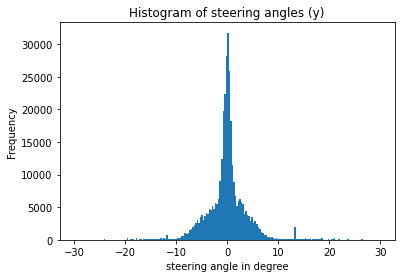

In [4]:
plt.hist(df['angle'], bins = 200)
plt.title('Histogram of steering angles (y)')
plt.xlabel('steering angle in degree')
plt.ylabel('Frequency')
plt.savefig('histogram_y.png')

In [5]:
min(df['angle'])

-29.9

In [34]:
from fastkde import fastKDE
myPDF,axes = fastKDE.pdf(np.array(df['angle']), numPoints= 2**15 + 1)

/home/hofmancl/.local/lib/python3.8/site-packages/fastkde/fastKDE.py:464: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  *(1+sqrt(1-ecfThresh/ecfSq[iCalcPhi]))
/home/hofmancl/.local/lib/python3.8/site-packages/fastkde/fastKDE.py:463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  kappaSC[iCalcPhi] = (N/(2*(N-1)))\
/home/hofmancl/.local/lib/python3.8/site-packages/fastkde/fastKDE.py:472: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

In [12]:
min(axes)

-59.75

In [41]:
density = pd.DataFrame({'pdf': myPDF , 'axes': axes})
#density = density.loc[abs(density['axes']) <= 30,:]

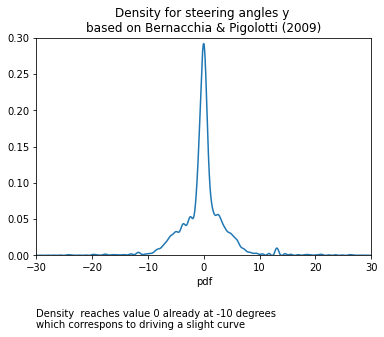

In [42]:
plt.plot(axes, myPDF)
plt.title('Density for steering angles y \nbased on Bernacchia & Pigolotti (2009)')
plt.xlabel('y')
plt.xlabel('pdf')
plt.xlim((-30,30))
plt.ylim((0,0.3))
plt.text( -30,  - 0.1,'Density  reaches value 0 already at -10 degrees \nwhich correspons to driving a slight curve')
plt.savefig('density.png')

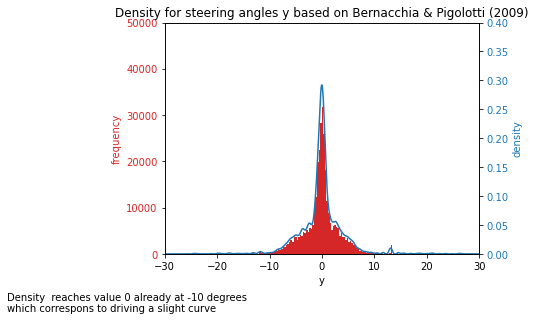

In [43]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('y')
ax1.set_ylabel('frequency', color=color)
ax1.hist(df['angle'], bins = 200, color = color) 
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((0, 50000))
ax1.set_xlim((-30, 30))

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('density', color=color)  # we already handled the x-label with ax1

ax2.plot(axes, myPDF, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim((0, 0.4))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.set_title('Density for steering angles y based on Bernacchia & Pigolotti (2009)')
ax2.text( -60,  - 0.1,'Density  reaches value 0 already at -10 degrees \nwhich correspons to driving a slight curve')
plt.show()
fig.savefig('hist_dens_overlaid.png')

In [44]:
min(abs(density.loc[density['pdf'] == 0, 'axes']))

12.083850097656253

In [45]:
# compute cdf
all_integrals = []
integral_before = 0
for i in tqdm(range(1,density.shape[0])):
    integral_now = integrate.trapz(density.loc[i-1:i,'pdf'] , density.loc[i-1:i, 'axes'])
    integral_now += integral_before
    integral_before = integral_now
    all_integrals.append(integral_now)
density.loc[1:,'cdf'] = all_integrals
density.loc[0,'cdf'] = 0

100%|██████████| 32768/32768 [00:14<00:00, 2316.56it/s]


In [46]:
def find_closest_element(y: float, arr: np.ndarray):
    index = np.searchsorted(arr,y)
    if (index >= 1) & (index < arr.shape[0]):
        res = [arr[index - 1], arr[index]]
    elif (index < arr.shape[0]):
        return np.array(index)
    else:
        return np.array(index - 1)

    if res[0] == res[1]:
        return np.array(index - 1)
    else:
        diff_pre = np.abs(y-res[0])
        diff_aft = np.abs(y-res[1])
        if diff_pre == diff_aft:
            return np.array(index - 1), 
        else:
            return index - 1 if diff_pre < diff_aft else index
def Fy(y, density):
    integral = density.loc[find_closest_element(y, density['axes']),'cdf']
    return(integral)  

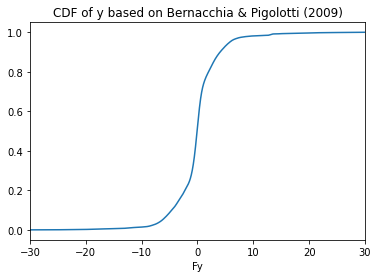

In [47]:
plt.plot(density['axes'], density['cdf'])
plt.title('CDF of y based on Bernacchia & Pigolotti (2009)')
plt.xlabel('y')
plt.xlabel('Fy')
plt.xlim((-30,30))
plt.savefig('Fy.png')

In [61]:
density_val = norm.ppf(Fy(30, density))
density_val

3.586835532454238

In [49]:
df['tr_angle2'] = df['angle'].apply(lambda x: norm.ppf(Fy(x, density)))

In [50]:
df['tr_angle2'].shape

(354347,)

In [62]:
max(df['angle'])

29.8

In [51]:
# normal distr
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 341398)


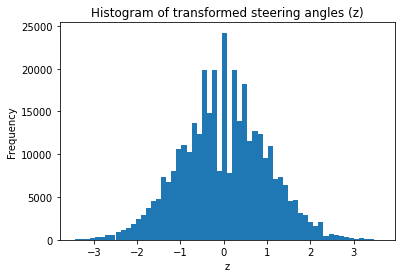

In [52]:
plt.hist(df['tr_angle2'], bins = 60)
plt.title('Histogram of transformed steering angles (z)')
plt.xlabel('z')
plt.ylabel('Frequency')
plt.savefig('histogram_z.png')

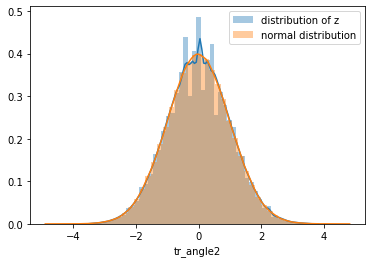

In [53]:
value = np.random.normal(loc=0,scale=1,size=df['tr_angle2'].shape[0])
f, ax = plt.subplots(1, 1)
sns.distplot(df['tr_angle2'], label = 'distribution of z')
sns.distplot(value, label = 'normal distribution')
ax.legend()
f.savefig('histogram_z_vs_normal_distr.png')

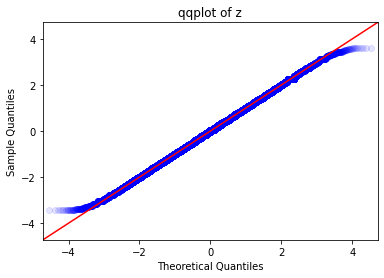

In [64]:
fig = sm.qqplot(df.loc[abs(df['angle']) < 30, 'tr_angle2'], stats.norm, fit=True, line="45")

dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[d.set_alpha(0.1) for d in dots]
plt.title('qqplot of z')
plt.savefig('qqplot_transformed_values.png')


In [55]:
max(df['angle'])

29.8

In [58]:
k2, p = stats.normaltest(df['tr_angle2'])

In [59]:
p

1.4358994499256908e-07

In [60]:
stats.shapiro(df['tr_angle2'])

/home/hofmancl/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(1.0004786252975464, 1.0)

In [ ]:
dens = np.sort(density['pdf'])

In [ ]:
plt.hist(df['angle'], bins = 100)